In [4]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Resize về 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset_path = 'D:/AI_Ex/final/garbage_classification_enhanced'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Chia train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class TinyCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 32x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 16x16
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 16x16
        x = self.pool(F.relu(self.conv3(x)))  # 8x8
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = TinyCNN().to(device)
total_params = count_parameters(model)
print(f"📊 Tổng số tham số học được: {total_params:,}")


📊 Tổng số tham số học được: 286,572


In [106]:
import torch
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Vòng lặp huấn luyện
epochs = 30
for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = correct / total * 100
    print(f"Epoch {epoch+1}: Loss={train_loss:.3f}, Accuracy={acc:.2f}%")

    # Early stop nếu accuracy > 95%
    if acc > 95:
        print("✅ Đã đạt yêu cầu accuracy > 95%. Dừng sớm.")
        break


Epoch 1: Loss=615.783, Accuracy=48.83%
Epoch 2: Loss=461.362, Accuracy=61.35%
Epoch 3: Loss=406.925, Accuracy=66.62%
Epoch 4: Loss=371.227, Accuracy=69.92%
Epoch 5: Loss=339.986, Accuracy=71.91%
Epoch 6: Loss=310.536, Accuracy=74.24%
Epoch 7: Loss=284.468, Accuracy=76.42%
Epoch 8: Loss=261.241, Accuracy=77.96%
Epoch 9: Loss=242.527, Accuracy=79.62%
Epoch 10: Loss=218.069, Accuracy=81.36%
Epoch 11: Loss=202.819, Accuracy=82.59%
Epoch 12: Loss=185.821, Accuracy=83.90%
Epoch 13: Loss=170.814, Accuracy=84.81%
Epoch 14: Loss=153.256, Accuracy=86.58%
Epoch 15: Loss=142.865, Accuracy=87.44%
Epoch 16: Loss=130.246, Accuracy=88.35%
Epoch 17: Loss=125.583, Accuracy=88.85%
Epoch 18: Loss=115.534, Accuracy=89.69%
Epoch 19: Loss=110.980, Accuracy=89.82%
Epoch 20: Loss=100.124, Accuracy=91.01%
Epoch 21: Loss=93.634, Accuracy=91.42%
Epoch 22: Loss=89.248, Accuracy=91.94%
Epoch 23: Loss=87.430, Accuracy=92.07%
Epoch 24: Loss=84.877, Accuracy=92.23%
Epoch 25: Loss=78.574, Accuracy=93.02%
Epoch 26: Loss

In [107]:
torch.save(model.state_dict(), "garbage_cnn.pt")
print("✅ Mô hình đã được lưu tại garbage_cnn.pt")


✅ Mô hình đã được lưu tại garbage_cnn.pt


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6112\3613668156.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("garbage_cnn.pt", map_locati

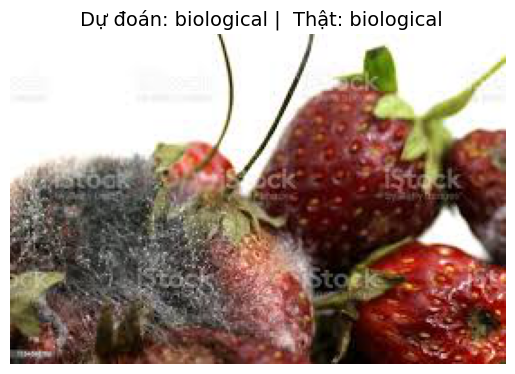

In [216]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

# Định nghĩa transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Mô hình TinyCNN
class TinyCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = TinyCNN().to(device)
model.load_state_dict(torch.load("garbage_cnn.pt", map_location=device))
model.eval()

# Load dataset
dataset_path = r"D:\AI_Ex\final\garbage_classification_enhanced"
dataset = datasets.ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes  # ['battery', 'biological', ..., 'white-glass']

# 🔍 Chọn ngẫu nhiên 1 ảnh từ dataset
index = random.randint(0, len(dataset) - 1)
img_tensor, label = dataset[index]  # img_tensor đã transform rồi
img_for_display = datasets.ImageFolder(dataset_path)[index][0]  # ảnh chưa transform để hiển thị

# Đưa ảnh vào mô hình
img_tensor = img_tensor.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = output.max(1)

predicted_label = class_names[predicted.item()]
true_label = class_names[label]

# Hiển thị
plt.imshow(img_for_display)
plt.title(f" Dự đoán: {predicted_label} |  Thật: {true_label}", fontsize=14)
plt.axis('off')
plt.show()
